# CSCD 319 - COMPUTER VISION

## LAB SESSION 2: 
### TOPIC:    Introduction to Convolutional Neural Networks (CNN) and MobileNet using Keras with Tensorflow.

## Convolutional Neural Network

In [1]:
# Import the necessary libraries that will be needed to carry out the tasks
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

### Data Preparation

The images included in the data directory are a random subset of the full cat and dog data set from the following Kaggle competition: https://www.kaggle.com/c/dogs-vs-cats/data 

The dataset contains 25,000 images of dogs and cats.

After downloading the dataset, you will get a zip file that contains a sampleSubmission file, a test.zip file and a train.zip file. You may delete the sampleSubmission file and the test.zip file as they will be irrelevant for our session. Ensure that your Notebook and the data files are not in the same directory as commiting to GitHub will send the images to your repository as well, which is not necessary.

In [2]:
# Organize data into train, valid, test dirs
os.chdir('../data/dogs-vs-cats')
if os.path.isdir('train/dog') is False:
    os.makedirs('train/dog')
    os.makedirs('train/cat')
    os.makedirs('valid/dog')
    os.makedirs('valid/cat')
    os.makedirs('test/dog')
    os.makedirs('test/cat')

    for i in random.sample(glob.glob('cat*'), 500):
        shutil.move(i, 'train/cat')      
    for i in random.sample(glob.glob('dog*'), 500):
        shutil.move(i, 'train/dog')
    for i in random.sample(glob.glob('cat*'), 100):
        shutil.move(i, 'valid/cat')        
    for i in random.sample(glob.glob('dog*'), 100):
        shutil.move(i, 'valid/dog')
    for i in random.sample(glob.glob('cat*'), 50):
        shutil.move(i, 'test/cat')      
    for i in random.sample(glob.glob('dog*'), 50):
        shutil.move(i, 'test/dog')

os.chdir('../../')

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../data/dogs-vs-cats'

In [ ]:
# Setting up paths for data files.

train_path = 'data/dogs-vs-cats/train'
valid_path = 'data/dogs-vs-cats/valid'
test_path = 'data/dogs-vs-cats/test'

In [ ]:
# We need to put the data in a format that the model understands.
# In keras, we do so with the ImageGenerator() method.
# This will create batches of data from the directory where the datasets resides
# And these batches of data will be passed to the sequential model

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['cat','dog'], batch_size=10)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['cat','dog'], batch_size=10)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['cat','dog'], batch_size=10, shuffle=False)

In [ ]:
# Verifying the number of classes and images for our train, valid and test sets
assert train_batches.n == 1000
assert valid_batches.n == 200
assert test_batches.n == 100
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2

In [ ]:
# Checking the indices of each label
test_batches.class_indices

In [ ]:
# Overview of images from a particular batch
imgs, labels = next(train_batches)

In [ ]:
# This function will plot images in the form of a grid with 1 row and 10 columns where images are place
# Function taken directly from Tensorflow website
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
# Plotting images from the 'imgs' batches along their labels
plotImages(imgs)
print(labels)

### Build and train a CNN

In [ ]:
# Using the keras sequential model to build our model

model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax'),
])

In [ ]:
# Check out a summary of our model
model.summary()

In [ ]:
# Calculating the number of trainable parameters in a model
model1 = Sequential([
    Dense(3, input_shape=(2,), activation='relu'),
    Dense(2, activation='softmax')
])

In [ ]:
model1.summary()

In [ ]:
model1.get_weights()

In [ ]:
# Preparing the model for training
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# We can now train our model
model.fit(x=train_batches, validation_data=valid_batches, epochs=3, verbose=2)

### Predict

In [ ]:
# Get a batch of test data from the test images and then plot that batch
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [ ]:
# View the unshuffled test set
test_batches.classes

In [ ]:
# Making a prediction on the test set
predictions = model.predict(x=test_batches, verbose=0)

In [ ]:
# Rounding the probabilities to zero and one
np.round(predictions)

In [ ]:
# Creating a confusion matrix to view the performance of the model on the test set
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=1))

In [ ]:
# Function to plot a confusion Matrix
# Directly copied from the Scikit Learn website
def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    print(cm)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# Checking the indices of each label
test_batches.class_indices

In [ ]:
# Defining the labels of the confusion Matrix and plotting it
cm_plot_labels = ['cat', 'dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

### ASSIGNMENT 1 - 3 marks

#### Improving model performance.

Tune the parameters of the Convolutional Neural Network above to achieve a better performance comparative to what was achieved in class.\
The sum of the True Positive value and that of the True Negative value should be greater than or equal to 70% of the total number of files in the test dataset.

You may achieve this through the following ways.
1. You may include more of the data files when training your model.
2. You may try out other types of optimizers.
3. You may change the learning rate.
4. You may add more layers to the Sequential model
5. Etc.

Use the resulting confusion matrix to determine the performance of your tuned model. 

#### DEADLINE: 
Sunday, April 2nd, 2021

In [11]:
# Organize data into train, valid, test dirs
os.chdir('C:/Users/cOVIDpOWER/Downloads/train/train')
if os.path.isdir('train/dog') is False:
    os.makedirs('train/dog')
    os.makedirs('train/cat')
    os.makedirs('valid/dog')
    os.makedirs('valid/cat')
    os.makedirs('test/dog')
    os.makedirs('test/cat')

    for i in random.sample(glob.glob('cat*'), 500):
        shutil.move(i, 'train/cat')      
    for i in random.sample(glob.glob('dog*'), 500):
        shutil.move(i, 'train/dog')
    for i in random.sample(glob.glob('cat*'), 100):
        shutil.move(i, 'valid/cat')        
    for i in random.sample(glob.glob('dog*'), 100):
        shutil.move(i, 'valid/dog')
    for i in random.sample(glob.glob('cat*'), 50):
        shutil.move(i, 'test/cat')      
    for i in random.sample(glob.glob('dog*'), 50):
        shutil.move(i, 'test/dog')

os.chdir('../../')

## MobileNet With Keras

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Run this cell to make sure that Tensorflow can identify your GPU if you are using a GPU
#physical_devices = tf.config.experimental.list_physical_devices('GPU')
#print("Num GPUs Available: ", len(physical_devices))
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [7]:
# Downloading MobileNet Model
mobile = tf.keras.applications.mobilenet.MobileNet()

In [ ]:
# Building a function to preprocess the Images with MobileNet Preprocessing function
def prepare_image(file):
    img_path = 'data/MobileNet-samples/'
    img = image.load_img(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

In [ ]:
# View the first image in the data set
from IPython.display import Image
Image(filename='data/MobileNet-samples/1.jpg', width=300, height=200)

In [ ]:
# Preprocess the image and display the possible predictions for the image (mostly the top 5 predictions)
preprocessed_image = prepare_image('1.jpg')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)  #Top five predictions from the 1000 possible ImageNet classes
results

In [ ]:
# Viewing the second image in the data set
Image(filename='data/MobileNet-samples/2.jpg', width=300, height=200)

In [ ]:
# Preprocess the image and display the possible predictions for the image (mostly the top 5 predictions)
preprocessed_image = prepare_image('2.jpg')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)
results

### ASSIGNMENT 2 - 2 marks

Download two different random images online and do the following:

1. View the image in your Notebook.
2. Preprocess the image and display the possible predictions for the image (the top 5 predictions) with the MobileNet model.

In [3]:
# Building a function to preprocess the Images with MobileNet Preprocessing function
def prepare_image(file):
    img_path = 'C:/Users/cOVIDpOWER/Downloads/Computer-Vision-Session2-master/Computer-Vision-Session2-master/'
    img = image.load_img( file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

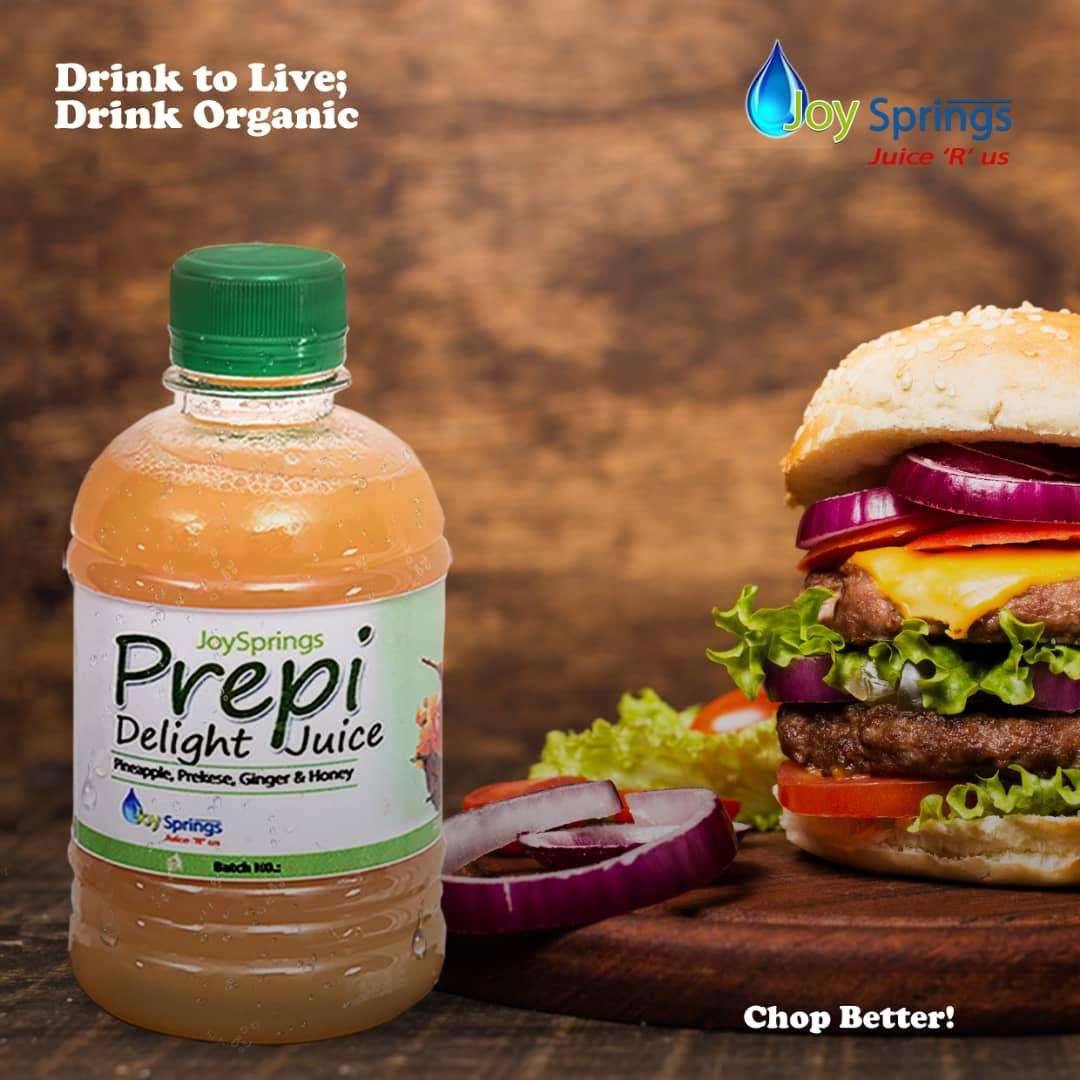

In [4]:
from IPython.display import Image
Image(filename='C:/Users/cOVIDpOWER/Downloads/Computer-Vision-Session2-master/Computer-Vision-Session2-master/pic1.jpeg', width=300, height=200)

In [8]:
# Preprocess the image and display the possible predictions for the image (mostly the top 5 predictions)
preprocessed_image = prepare_image('C:/Users/cOVIDpOWER/Downloads/Computer-Vision-Session2-master/Computer-Vision-Session2-master/pic1.jpeg')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)  #Top five predictions from the 1000 possible ImageNet classes
results

[[('n03690938', 'lotion', 0.4711548),
  ('n07697313', 'cheeseburger', 0.3778113),
  ('n04357314', 'sunscreen', 0.08036553),
  ('n03937543', 'pill_bottle', 0.019442486),
  ('n04557648', 'water_bottle', 0.01586618)]]

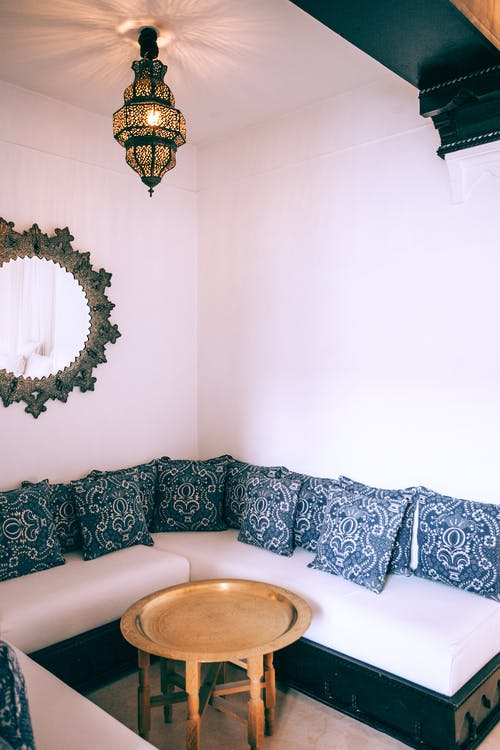

In [9]:
# Viewing the second image in the data set
Image(filename='C:/Users/cOVIDpOWER/Downloads/Computer-Vision-Session2-master/Computer-Vision-Session2-master/pic2.jpeg', width=300, height=200)

In [10]:
# Preprocess the image and display the possible predictions for the image (mostly the top 5 predictions)
preprocessed_image = prepare_image('C:/Users/cOVIDpOWER/Downloads/Computer-Vision-Session2-master/Computer-Vision-Session2-master/pic2.jpeg')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)  #Top five predictions from the 1000 possible ImageNet classes
results

[[('n03201208', 'dining_table', 0.39240423),
  ('n02788148', 'bannister', 0.18426535),
  ('n02808440', 'bathtub', 0.1472066),
  ('n04493381', 'tub', 0.08864687),
  ('n04344873', 'studio_couch', 0.048081007)]]